In [180]:
using Oceananigans
using Oceananigans.Operators
using JLD2
using CairoMakie

In [204]:
file = jldopen("$input_folder/$filename.jld2")

JLDFile /gpfs/fs0/scratch/n/ngrisoua/atkin163/Project/front-init-test/initialisation.jld2 (read-only)
 ├─📂 grid
 │  ├─🔢 Nx
 │  ├─🔢 Ny
 │  ├─🔢 Nz
 │  ├─🔢 Hx
 │  ├─🔢 Hy
 │  ├─🔢 Hz
 │  ├─🔢 Lx
 │  └─ ⋯ (14 more entries)
 └─ ⋯ (4 more entries)

In [194]:
file["timeseries/u/serialized/boundary_conditions"]

Oceananigans.FieldBoundaryConditions, with boundary conditions
├── west: Nothing
├── east: Nothing
├── south: Nothing
├── north: Nothing
├── bottom: Nothing
├── top: Nothing
└── immersed: FluxBoundaryCondition: Nothing

In [165]:
#=
    Calculate balances for the down-front mean momentum and buoyancy equations
=#

input_folder = "../../scratch/Project/front-init-test"
output_folder = "../../scratch/Project/front-init-test"

filename = "initialisation"

# Get grid and iterations
grid, frames = jldopen("$input_folder/$filename.jld2") do file
    file["serialized/grid"], parse.(Int, keys(file["timeseries/t"]))
end
# Get simulation parameters
sp = jldopen("$input_folder/parameters.jld2") do file
    (; f=1)
end

# input: u, v, w, b, ϕ
# Create a field for each by loading the first iteration in file

u = FieldTimeSeries("$input_folder/$filename.jld2", "u"; iterations=frames[51])[1]
v = FieldTimeSeries("$input_folder/$filename.jld2", "v"; iterations=frames[51])[1]
w = FieldTimeSeries("$input_folder/$filename.jld2", "w"; iterations=frames[51])[1]
b = FieldTimeSeries("$input_folder/$filename.jld2", "b"; iterations=frames[51])[1]
φ = FieldTimeSeries("$input_folder/$filename.jld2", "φ"; iterations=frames[1])[1]

# Makes sense to compute the mean fields now
u_dfm = Field(Average(u; dims=2))
v_dfm = Field(Average(v; dims=2))
w_dfm = Field(Average(w; dims=2))
b_dfm = Field(Average(b; dims=2))
φ_dfm = Field(Average(φ; dims=2))

# Keep all the fields in a NamedTuple
pp_fields = (; u_dfm, u, v_dfm, v, w_dfm, w, b_dfm, b, φ_dfm)

# Helper function for computing the correlations
@inline a′b′(i, j, k, grid, a, a_dfm, b, b_dfm) = @inbounds (a[i, j, k]-a_dfm[i, j, k]) * (b[i, j, k]-b_dfm[i, j, k])

# Kernel functions for the correlations

function u′u′_kernel_func(i, j, k, grid, u, u_dfm)
    return a′b′(i, j, k, grid, u, u_dfm, u, u_dfm)
end

u′u′_dfm = Field(Average(KernelFunctionOperation{Face, Center, Center}(u′u′_kernel_func, grid, u, u_dfm); dims=2))
ᶜ

#=
# Helper function for the advection
@inline ab(i, j, k, grid, a, b) = @inbounds a[i, j, k] * b[i, j, k]

# Kernel functions for the u balance
# Fields are interpolated onto Face, Nothing, Center
# Signs are such that all will sum to ∂uᶠᶜᶜ∂t

# Coriolis
function fv_kernel_func(i, j, k, grid, pp_fields, sp)
    return sp.f * ℑxᶠᵃᵃ(i, j, k, grid, pp_fields.v_dfm)
end

# Pressure
function φx_kernel_func(i, j, k, grid, pp_fields, sp)
    return -∂xᶠᶜᶜ(i, j, k, grid, pp_fields.φ_dfm)
end

# Horizontal turbulent flux 
function u′u′x_kernel_func(i, j, k, grid, pp_fields, sp)
    return -ℑxᶠᵃᵃ(i, j, k, grid, ∂xᶜᶜᶜ, a′b′, pp_fields.u, pp_fields.u_dfm, pp_fields.u, pp_fields.u_dfm)
end
#=
# Vertical turbulent flux
function w′u′z_kernel_func(i, j, k, grid, pp_fields, sp)
    w′ᶠᶜᶜ = ℑxzᶠᵃᶜ(i, j, k, grid, pp_fields.w′)
    return -ℑxᶠᵃᵃ(i, j, k, grid, ∂xᶜᶜᶜ, ab, w′ᶠᶜᶜ, pp_fields.u′)
end
=#
# Horizontal advection
function uux_kernel_func(i, j, k, grid, pp_fields, sp)
    return ℑxᶠᵃᵃ(i, j, k, grid, ∂xᶜᶜᶜ, ab, pp_fields.u_dfm, pp_fields.u_dfm)
end

# Vertical advection
function wuz_kernel_func(i, j, k, grid, pp_fields, sp)
    wᶠᶜᶜ = ℑxzᶠᵃᶜ(i, j, k, grid, pp_fields.w_dfm)
    return -ℑzᵃᵃᶜ(i, j, k, grid, ∂zᶜᶜᶠ, wᶠᶜᶜ, pp_fields.u_dfm)
end


fv = Field(KernelFunctionOperation{Face, Nothing, Center}(fv_kernel_func, grid, pp_fields, sp))
φx = Field(KernelFunctionOperation{Face, Nothing, Center}(φx_kernel_func, grid, pp_fields, sp))
u′u′x = Field(KernelFunctionOperation{Face, Nothing, Center}(u′u′x_kernel_func, grid, pp_fields, sp))
#w′u′z = Field(KernelFunctionOperation{Face, Nothing, Center}(w′u′z_kernel_func, grid, pp_fields, sp))
uux = Field(KernelFunctionOperation{Face, Nothing, Center}(uux_kernel_func, grid, pp_fields, sp))
wuz = Field(KernelFunctionOperation{Face, Nothing, Center}(wuz_kernel_func, grid, pp_fields, sp))
=#

1001×1×100 Field{Face, Nothing, Center} reduced over dims = (2,) on RectilinearGrid on CPU
├── data: OffsetArrays.OffsetArray{Float64, 3, Array{Float64, 3}}, size: (1001, 1, 100)
├── grid: 1000×64×100 RectilinearGrid{Float64, Bounded, Periodic, Bounded} on CPU with 3×3×3 halo
├── operand: mean! over dims (2,) of KernelFunctionOperation at (Face, Center, Center)
└── status: time=0.0

In [200]:
u′u′_dfm.boundary_conditions

Oceananigans.FieldBoundaryConditions, with boundary conditions
├── west: Nothing
├── east: Nothing
├── south: Nothing
├── north: Nothing
├── bottom: Nothing
├── top: Nothing
└── immersed: FluxBoundaryCondition: Nothing

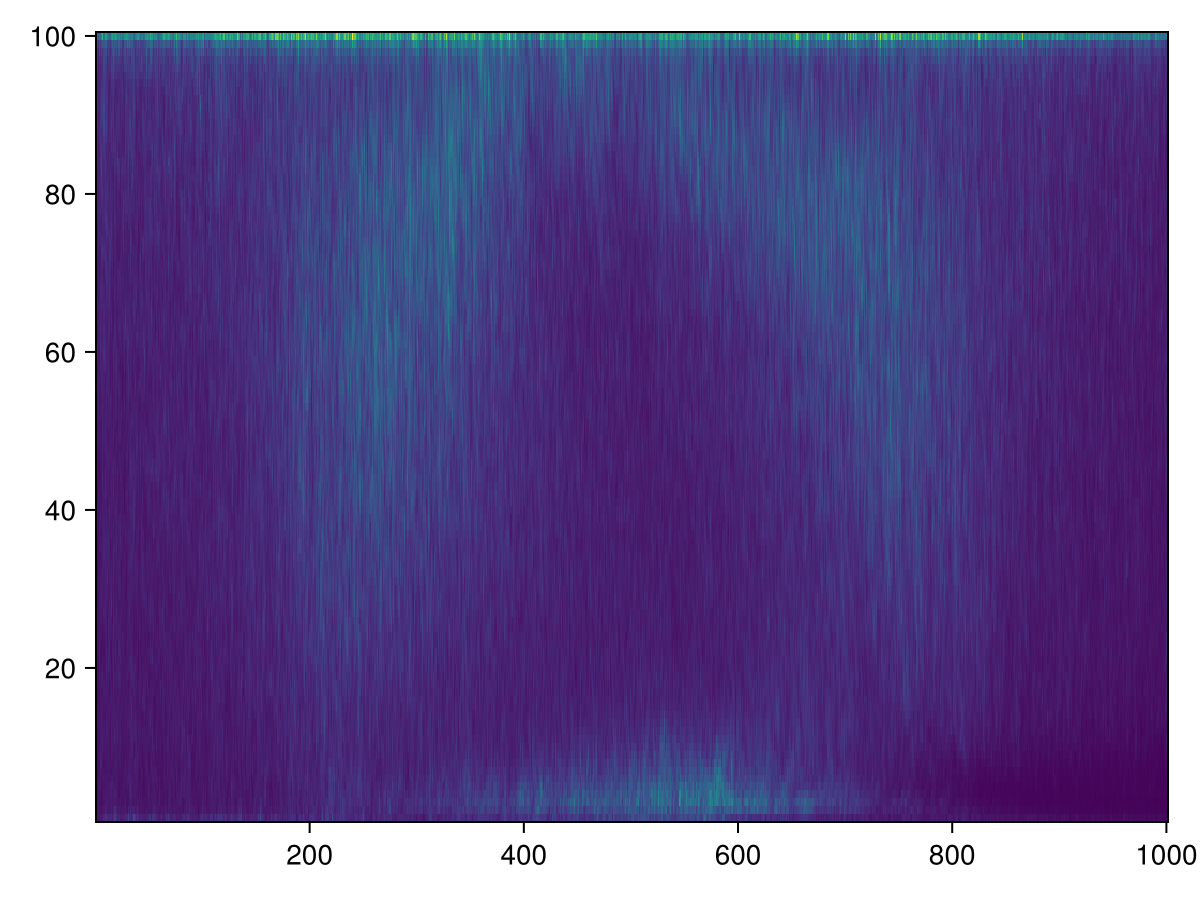

In [198]:

heatmap(interior(u′u′_dfm, :, 1, :))

In [ ]:
# Create the output fields


function save_to_file(terms, filename, frame)
    # Loop over key value pairs in terms
    
    # Save to JLD2 file
    
    jldopen(filename, "a") do file
        file["timeseries/$key/$frame"] = data
    end
end

# Loop over frames and add the data into the fields
for frame in frames
    # Read in new data (assumes constant bc)
    
    # Compute
    compute!.(pp_fields)
    # Compute output fields
    compute!.(u_terms)
    # Save output fields to file
    
end

# Save the 